## WÜRTH ITALIA – Capstone Projects: Product Recommendation Project 2
### Name: Gyeongwon Song
### Student ID: 22297

# 1. Importing Libraries and Loading Dataset

In [1]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors

In [2]:
df = pd.read_csv('products_recommendation_dataset.txt', sep = ',')

df.head()

/var/folders/16/4jwzrfr95fn8lpryr55z4smh0000gn/T/ipykernel_41726/4273565468.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('products_recommendation_dataset.txt', sep = ',')


,Id,customerid,level5id,dat_action,actions_type,actions_count,att_marketsegment,att_saleschannel,att_sector,level4id,level3id,level2id,level1id
0,1,2358331266,3008060502,2022-11-01 00:00:00,ecommerceAbandonedCart,1,7,3,B,30080605,300806,3008,30
1,2,8357082266,3004010408,2022-11-01 00:00:00,ecommerceAbandonedCart,1,23,3,E,30040104,300401,3004,30
2,3,8357082266,3004010408,2022-11-01 00:00:00,search,1,23,3,E,30040104,300401,3004,30
3,4,2358331266,2002230513,2022-11-01 00:00:00,ecommerceAbandonedCart,1,7,3,B,20022305,200223,2002,20
4,5,263701366,6022072102,2022-11-01 00:00:00,action,1,23,1,E,60220721,602207,6022,60


# 2. Data Preparation

In [3]:
# Dropping the first column
df.drop(df.columns[0], axis=1, inplace = True)

In [4]:
# Check for duplicates
def check_duplicates(dataframe):
    return dataframe.duplicated().sum()

print("Number of duplicated rows based on 'level5id':", check_duplicates(df['level5id']))

Number of duplicated rows based on 'level5id': 6785425


## Check Missing Values
There are 6379695 null values in dat_action, actions_type(no_data), and actions_count(0)

In [5]:
df.isnull().sum()

customerid                 0
level5id                   0
dat_action           6379695
actions_type               0
actions_count              0
att_marketsegment          0
att_saleschannel           0
 att_sector                0
 level4id                  0
 level3id                  0
 level2id                  0
 level1id                  0
dtype: int64

In [6]:
# Filter the DataFrame where actions_type is 'no_data'
filtered_df = df[df['actions_type'] == 'no_data']

# Get the value counts for customerid in the filtered DataFrame
filtered_df['customerid'].value_counts()

customerid
4149010266    945
3210468266    945
5625078266    945
3370078266    945
6845968266    945
             ... 
6511304266    945
4959204266    945
438204266     945
4057204266    945
8987864176    945
Name: count, Length: 6751, dtype: int64

## Drop Missing Values

In [7]:
df.dropna(axis=0, inplace=True)

In [8]:
df.isnull().sum()

customerid           0
level5id             0
dat_action           0
actions_type         0
actions_count        0
att_marketsegment    0
att_saleschannel     0
 att_sector          0
 level4id            0
 level3id            0
 level2id            0
 level1id            0
dtype: int64

### Convert dat_action to datetime

In [9]:
df['dat_action'] = pd.to_datetime(df['dat_action'])

# Get value counts for each date
value_counts = df['dat_action'].value_counts().sort_index()

### Customers’online and offline behaviour

In [10]:
# # Customers’online bahaviour
online = df[df['actions_type'] != 'purchase']

# Customers’offline bahaviour
offline = df[df['actions_type'] == 'purchase']

# 3. Exploratory Data Analysis

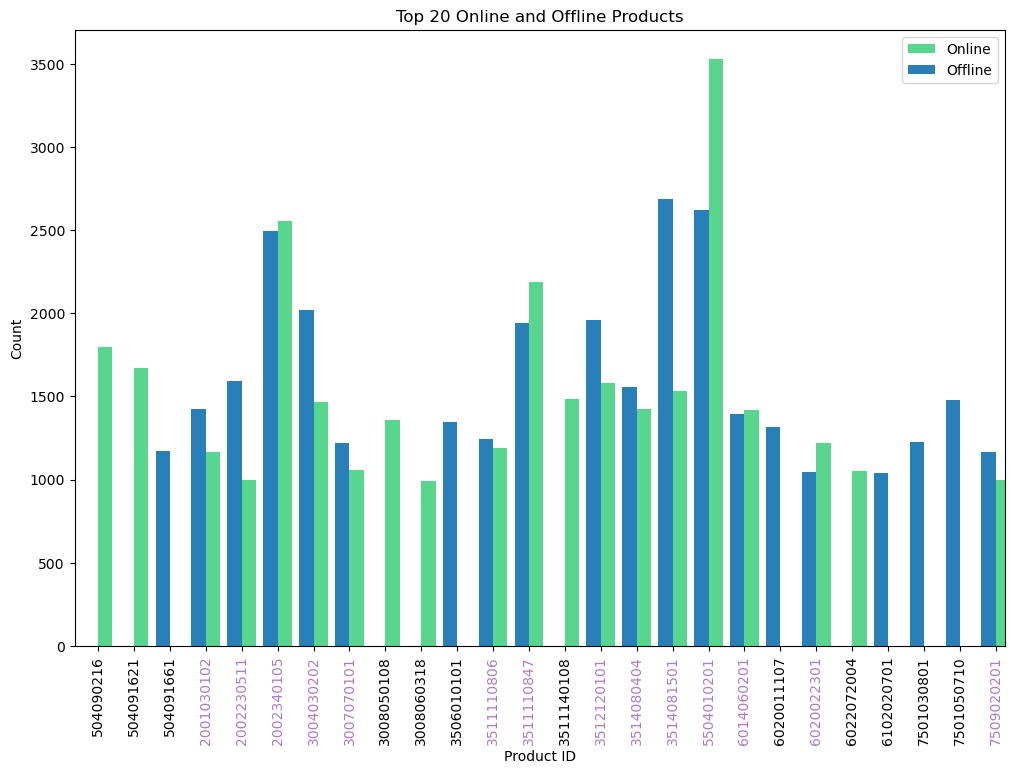

In [11]:
top_20_online = online['level5id'].value_counts().head(20)
top_20_offline = offline['level5id'].value_counts().head(20)

# Create a DataFrame for plotting
top_products = pd.DataFrame({
    'Online': top_20_online,
    'Offline': top_20_offline
}).fillna(0)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

top_products['Online'].plot(kind='bar', color='#58D68D', position=0, width=0.4, ax=ax, label='Online')
top_products['Offline'].plot(kind='bar', color='#2980B9', position=1, width=0.4, ax=ax, label='Offline')

# Highlight common products
common_products = top_products[(top_products['Online'] > 0) & (top_products['Offline'] > 0)].index
for product in common_products:
    ax.get_xticklabels()[top_products.index.get_loc(product)].set_color('#AF7AC5')

ax.set_title('Top 20 Online and Offline Products')
ax.set_xlabel('Product ID')
ax.set_ylabel('Count')
ax.legend()

plt.show()

## Top 20 'ecommerceAbandonedCart' level5id values in 'top_products' list	

In [12]:
# Filter df for ecommerceAbandonedCart actions
ecommerce_abandoned_cart = df[df['actions_type'] == 'ecommerceAbandonedCart']

# Get top 20 level5id by actions_count
top_20_abandoned_cart = ecommerce_abandoned_cart.groupby('level5id')['actions_count'].sum().nlargest(20)

# Check if top 20 level5id are in top_products list
top_20_in_top_products = top_20_abandoned_cart.index.isin(top_products.index)

# Check for duplicates in top 20 level5id
duplicates = top_20_abandoned_cart.index.duplicated()

# Output the results
print("Top 20 'ecommerceAbandonedCart' level5id values in 'top_products' list:")
print(top_20_abandoned_cart.index[top_20_in_top_products])

print("\nAny duplicates in the top 20 'ecommerceAbandonedCart' level5id values:")
print(duplicates.any())

Top 20 'ecommerceAbandonedCart' level5id values in 'top_products' list:
Index([5504010201, 3511110847, 3511140108, 3514080404, 3514081501, 3512120101,
       3511110806, 6014060201, 7501030801, 3004030202,  504091621, 2002340105,
        504090216],
      dtype='int64', name='level5id')

Any duplicates in the top 20 'ecommerceAbandonedCart' level5id values:
False


# 4. Product Recommendation

## Customer-Item Matrix

In [13]:
customer_item_matrix = df.pivot_table(index='customerid',columns='level5id',values='actions_count',aggfunc='sum')

In [14]:
customer_item_matrix.head()

level5id,46228,501010204,501010206,501090140,503010409,503010517,503010518,503011304,503011305,503011306,...,50011201539,60150111220,60150111223,60150111224,75010308133,75010309204,75010309205,75040402090,75090101117,75090101166
customerid,,,,,,,,,,,,,,,,,,,,,
11448266,NaN,NaN,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,2.0,NaN,1.0,NaN,NaN,NaN,NaN
30874266,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40422266,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,2.0,NaN,NaN
45713266,NaN,1.0,1.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50597266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
customer_item_matrix.shape

(607, 945)

In [16]:
# Assuming user-item matrix is already computed
# Convert ratings to binary (1 for rated, 0 for not rated)
customer_item_matrix = customer_item_matrix.applymap(lambda x: 1 if x>0 else 0)

In [17]:
customer_item_matrix.head()

level5id,46228,501010204,501010206,501090140,503010409,503010517,503010518,503011304,503011305,503011306,...,50011201539,60150111220,60150111223,60150111224,75010308133,75010309204,75010309205,75040402090,75090101117,75090101166
customerid,,,,,,,,,,,,,,,,,,,,,
11448266,0,0,1,0,0,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
30874266,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
40422266,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
45713266,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50597266,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


## Sparse Matrix Visualization

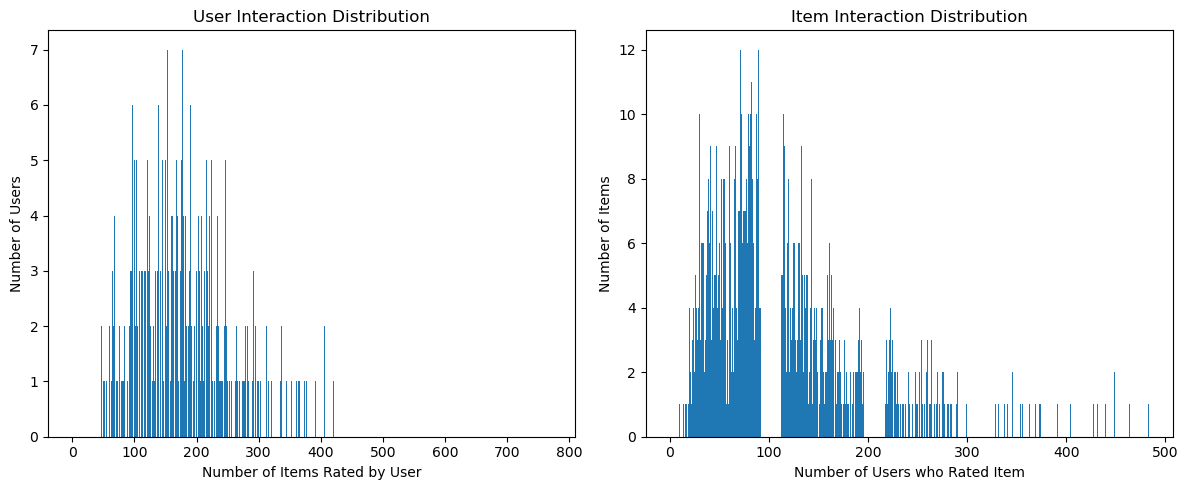

In [18]:
# 사용자별 평가한 아이템 수
user_interactions = np.sum(customer_item_matrix != 0, axis=1)
# 아이템별 평가된 사용자 수
item_interactions = np.sum(customer_item_matrix != 0, axis=0)

# 히스토그램 그리기
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].hist(user_interactions, bins=range(0, max(user_interactions)+1), align='left', rwidth=0.8)
axs[0].set_xlabel('Number of Items Rated by User')
axs[0].set_ylabel('Number of Users')
axs[0].set_title('User Interaction Distribution')

axs[1].hist(item_interactions, bins=range(0, max(item_interactions)+1), align='left', rwidth=0.8)
axs[1].set_xlabel('Number of Users who Rated Item')
axs[1].set_ylabel('Number of Items')
axs[1].set_title('Item Interaction Distribution')

plt.tight_layout()
plt.show()


# 4.1 User-based Collaborative Filtering

## User to User Similarity Matrix

In [19]:
#  Computing Cosine Similarity between users
user_to_user_sim_matrix = pd.DataFrame(cosine_similarity(customer_item_matrix.fillna(0)))
user_to_user_sim_matrix.columns = customer_item_matrix.index
user_to_user_sim_matrix['customerid'] = customer_item_matrix.index
user_to_user_sim_matrix = user_to_user_sim_matrix.set_index('customerid')

In [20]:
user_to_user_sim_matrix.head()

customerid,11448266,30874266,40422266,45713266,50597266,55162266,55173266,63016266,85808266,94301366,...,9856459266,9873191366,9894970266,9912592266,9919687266,9935934266,9939528076,9947561266,9954590266,9957703266
customerid,,,,,,,,,,,,,,,,,,,,,
11448266,1.000000,0.270484,0.317635,0.385215,0.115922,0.402758,0.224434,0.243108,0.298581,0.352450,...,0.220737,0.189862,0.135242,0.345959,0.308884,0.266037,0.186857,0.300188,0.157062,0.111752
30874266,0.270484,1.000000,0.279273,0.303499,0.140351,0.309460,0.301622,0.342171,0.298936,0.385935,...,0.260574,0.265238,0.131579,0.267951,0.329029,0.296480,0.176746,0.265015,0.164014,0.090201
40422266,0.317635,0.279273,1.000000,0.422855,0.192287,0.447834,0.191460,0.285162,0.283014,0.486373,...,0.334767,0.218033,0.151082,0.289343,0.354715,0.408339,0.276742,0.278609,0.256807,0.079444
45713266,0.385215,0.303499,0.422855,1.000000,0.200618,0.494931,0.258146,0.339822,0.256839,0.476102,...,0.352630,0.274142,0.146606,0.381994,0.408041,0.347725,0.242536,0.339683,0.232090,0.059508
50597266,0.115922,0.140351,0.192287,0.200618,1.000000,0.119564,0.073367,0.198680,0.114708,0.232973,...,0.210464,0.139250,0.039474,0.159384,0.137545,0.197653,0.116652,0.113578,0.117662,0.016913


## Making Recommendations

## Items Bought by a Specific User (e.g., CustomerID: 50597266)

In [21]:
items_bought_by_A = set(customer_item_matrix.loc[50597266].index[np.nonzero(customer_item_matrix.loc[50597266])])

In [22]:
items_bought_by_A

{503011306,
 504020117,
 504040201,
 2001021124,
 2001021143,
 2001021144,
 2001021317,
 2004020403,
 2009030321,
 3003100201,
 3004040301,
 3004040701,
 3004050607,
 3005040922,
 3005040923,
 3005041118,
 3005071802,
 3005090103,
 3005090108,
 3007030201,
 3007050301,
 3007090202,
 3008080101,
 3010140815,
 3010141401,
 3501010301,
 3501010703,
 3502010601,
 3502020201,
 3503010302,
 3508070536,
 3511090407,
 3511110831,
 3511110847,
 3511120103,
 3511120104,
 3511120112,
 3511130302,
 3511140108,
 3511180201,
 3512170302,
 3513010527,
 3513011401,
 3513011402,
 3514080601,
 3514081501,
 4502080107,
 5002130102,
 6005020307,
 6005020312,
 6005020501,
 6011010101,
 6013040718,
 6016060507,
 6016060604,
 6019020401,
 6019160801,
 6020022301,
 6101020404,
 6102050301,
 6502031404,
 6503040314,
 6503040805,
 6503090209,
 7002011301,
 7501030806,
 7501030930,
 7504040208,
 7505040102,
 7505040103,
 7505040502,
 7505040703,
 7505040704,
 7505040811,
 8001050601,
 8001051204}

In [23]:
set_size = len(items_bought_by_A)
print(f"Size of the set: {set_size}")

Size of the set: 76


## Items Bought by a Specific User (e.g., CustomerID: 9873191366)

In [24]:
items_bought_by_B = set(customer_item_matrix.loc[9873191366].index[np.nonzero(customer_item_matrix.loc[9873191366])])

In [25]:
set_size = len(items_bought_by_B)
print(f"Size of the set: {set_size}")

Size of the set: 133


In [26]:
items_bought_by_B

{504020117,
 504090216,
 504091606,
 508030486,
 2007100102,
 2009030135,
 2012011005,
 2012011006,
 2012011105,
 2012040120,
 2012040301,
 2103010101,
 2103010119,
 2103010120,
 3003070201,
 3004030201,
 3004030202,
 3004030208,
 3004040601,
 3004050111,
 3004050701,
 3005030201,
 3005030202,
 3005090103,
 3007050103,
 3007070101,
 3007070103,
 3007120903,
 3007150102,
 3008060318,
 3008080102,
 3008080503,
 3008090101,
 3502010123,
 3502020204,
 3503010302,
 3511110806,
 3511110847,
 3512060203,
 3512120410,
 3512121107,
 3512122801,
 3512170302,
 3513010522,
 3514080404,
 3514081501,
 5001020117,
 5001030203,
 5001030219,
 5001030716,
 5001060193,
 5001080109,
 5002130102,
 5504010201,
 5504011101,
 5505030903,
 6004050202,
 6005010341,
 6005020414,
 6005020501,
 6005030602,
 6005030606,
 6010021205,
 6012030404,
 6012030901,
 6013010803,
 6013010806,
 6013011003,
 6013011004,
 6013011102,
 6013030301,
 6013040401,
 6013060501,
 6014010103,
 6014040201,
 6014050202,
 6014050303,
 60

In [27]:
items_to_recommend_User_B = items_bought_by_A - items_bought_by_B

In [28]:
items_to_recommend_User_B

{503011306,
 504040201,
 2001021124,
 2001021143,
 2001021144,
 2001021317,
 2004020403,
 2009030321,
 3003100201,
 3004040301,
 3004040701,
 3004050607,
 3005040922,
 3005040923,
 3005041118,
 3005071802,
 3005090108,
 3007030201,
 3007050301,
 3007090202,
 3008080101,
 3010140815,
 3010141401,
 3501010301,
 3501010703,
 3502010601,
 3502020201,
 3508070536,
 3511090407,
 3511110831,
 3511120103,
 3511120104,
 3511120112,
 3511130302,
 3511140108,
 3511180201,
 3513010527,
 3513011401,
 3513011402,
 3514080601,
 4502080107,
 6005020307,
 6005020312,
 6011010101,
 6013040718,
 6016060507,
 6016060604,
 6101020404,
 6503040314,
 6503040805,
 7002011301,
 7501030806,
 7501030930,
 7504040208,
 7505040102,
 7505040103,
 7505040502,
 7505040703,
 7505040704,
 7505040811,
 8001050601,
 8001051204}

In [29]:
set_size = len(items_to_recommend_User_B)
print(f"Size of the set: {set_size}")

Size of the set: 62


We picked a random customer ID and found some recommendation items for User B based on User A

# 4.2 K-Nearest Neighbors (KNN) Algorithm

In [30]:
# Example code to normalize user-item matrix
normalized_matrix = customer_item_matrix.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis=0)

In [31]:
normalized_matrix.head()

level5id,46228,501010204,501010206,501090140,503010409,503010517,503010518,503011304,503011305,503011306,...,50011201539,60150111220,60150111223,60150111224,75010308133,75010309204,75010309205,75040402090,75090101117,75090101166
customerid,,,,,,,,,,,,,,,,,,,,,
11448266,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
30874266,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40422266,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
45713266,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50597266,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
# Initialize the KNN model
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')

# Fit the model
knn_model.fit(normalized_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [34]:
# Example function to get recommendations
def get_recommendations(user_id, model, customer_item_matrix, num_recommendations=10):
    distances, indices = model.kneighbors(customer_item_matrix.iloc[user_id, :].values.reshape(1, -1), n_neighbors=num_recommendations+1)
    recommended_items = []
    for i in range(1, len(distances.flatten())):
        recommended_items.append(customer_item_matrix.columns[indices.flatten()[i]])
    return recommended_items

# Finding all indexes where customerid matches
customer_id = '9935934266'
matching_indexes = [idx for idx, idx_value in enumerate(customer_item_matrix.index) if str(idx_value) == customer_id]

if len(matching_indexes) == 0:
    print(f"No records found for customer ID: {customer_id}")
else:
    for customerid_index in matching_indexes:
        recommendations = get_recommendations(customerid_index, knn_model, normalized_matrix)
        print(f"Recommendations for customer ID {customer_id} at index {customerid_index}:")
        print(recommendations)


Recommendations for customer ID 9935934266 at index 602:
[2009020129, 1006010206, 3511110806, 3507040101, 5503010601, 4507010101, 3003070902, 3511130302, 6004050302, 3502010204]
